#Импорт Библиотек и настройка профиля kaggle

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import math
import seaborn as sns
from sklearn.neighbors import  KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, TargetEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, make_scorer, f1_score, mean_absolute_error, mean_squared_error, r2_score, f1_score, accuracy_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV


In [4]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


#Классификация

##Подготовка данных



###Скачивание датасета

In [ ]:
!kaggle datasets download -d shrutimechlearn/churn-modelling
!unzip churn-modelling

Dataset URL: https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling
License(s): unknown
churn-modelling.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  churn-modelling.zip
replace Churn_Modelling.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Churn_Modelling.csv     


###Исходные данные

In [ ]:
df = pd.read_csv("Churn_Modelling.csv")
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Удалим идентификаторы не несущие полезной информации

In [ ]:
df.drop(["RowNumber", "CustomerId", "Surname"], axis=1,inplace=True)

###Проверка наличия нулевых значений

In [ ]:
df.isnull().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


###Обработка категориальных признаков

Проверим количество уникальных значений категориальных признаков для выбора подходящего метода кодировки

In [ ]:
df.select_dtypes(include=["object"]).nunique()

,0
Geography,3
Gender,2


Так как категориальные признаки имеют маленькое количество уникальных значений применим кодировку One-Hot

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
categorical_columns = df.select_dtypes(include=['object']).columns.to_list()
encoded = pd.DataFrame(encoder.fit_transform(df[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))
df = pd.concat([df, encoded], axis=1)
df.drop(categorical_columns, axis=1, inplace=True)

###Разделим датасет на train test и validation

In [ ]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(df.drop(columns="Exited"), df["Exited"], test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.2)

###Нормализация

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Сохраним данные бейзлайна

In [ ]:
X_train_baseline, X_test_baseline, Y_train_baseline, Y_test_baseline = X_train, X_test, Y_train, Y_test

##Бейзлайн


In [ ]:
classifier = KNeighborsClassifier()
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)

f1 = f1_score(Y_test, Y_pred, pos_label=1)

print(classification_report(Y_test, Y_pred))
print("F1 (class 1):", f1)

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1576
           1       0.60      0.27      0.37       424

    accuracy                           0.81      2000
   macro avg       0.71      0.61      0.63      2000
weighted avg       0.78      0.81      0.78      2000

F1 (class 1): 0.3713355048859935


##Улучшение бейзлайна

Для улучшения качества модели мы можем предпринять следующие шаги:
- Использовать ресемплинг для балансировки классов
- Выбрать самые значимые признаки
- Подобрать оптимальные гиперпараметры

###Ресемплинг

Text(0.5, 1.0, 'Распределение данных')

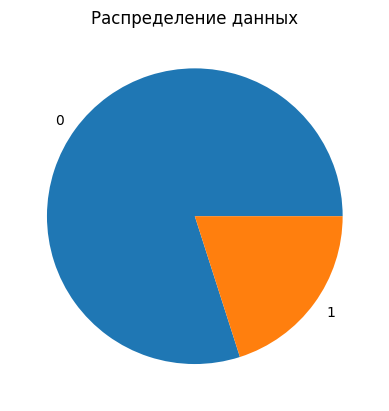

In [ ]:
plt.pie(Y_train.value_counts(), labels = ['0', '1'])
plt.title("Распределение данных")

Text(0.5, 1.0, 'Распределение данных после ресэмплинга')

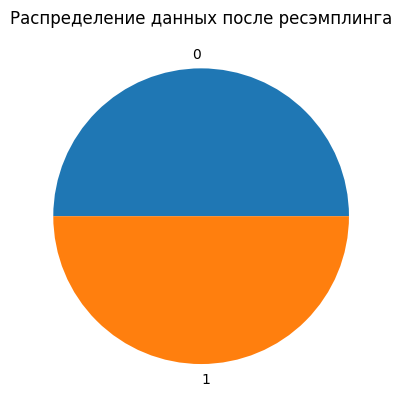

In [ ]:
sm = SMOTE()
X_train, Y_train = sm.fit_resample(X_train, Y_train)
plt.pie(Y_train.value_counts(), labels = ['0', '1'])
plt.title("Распределение данных после ресэмплинга")

In [ ]:
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_val)

f1 = f1_score(Y_val, Y_pred, pos_label=1)

print(classification_report(Y_val, Y_pred))
print("F1 (class 1):", f1)

              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1271
           1       0.40      0.65      0.49       329

    accuracy                           0.73      1600
   macro avg       0.65      0.70      0.65      1600
weighted avg       0.79      0.73      0.75      1600

F1 (class 1): 0.4942263279445728


После После ресэмплинга общая точность модели упала, но f1 минорного класса увеличился

###Важность признаков

In [ ]:
scorer = make_scorer(f1_score, pos_label=1) #Максимизируем f1 для класса 1
feature_importance = permutation_importance(classifier, X_val, Y_val, scoring=scorer)
importance_mask = feature_importance.importances_mean > 0 #удалим признаки которые вредят модели

X_train = X_train[:, importance_mask]
X_val = X_val[:, importance_mask]
X_test = X_test[:, importance_mask]

In [ ]:
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_val)

f1 = f1_score(Y_val, Y_pred, pos_label=1)

print(classification_report(Y_val, Y_pred))
print("F1 (class 1):", f1)

              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1271
           1       0.43      0.69      0.53       329

    accuracy                           0.75      1600
   macro avg       0.67      0.73      0.68      1600
weighted avg       0.81      0.75      0.76      1600

F1 (class 1): 0.5272938443670151


Отбор признаков позволил еще немного повысить f1 минорного класса

###Подбор гиперпараметров

In [ ]:

params = {"n_neighbors":range(3, 50, 2), "weights":["distance", "uniform"], "metric":["l1", "l2"]}
grid = GridSearchCV(KNeighborsClassifier(), params, cv=5, refit=True, scoring = scorer)
grid.fit(X_train, Y_train)
print("Лучшие гиперпараметры: ",grid.best_params_, grid.best_score_)

Лучшие гиперпараметры:  {'metric': 'l1', 'n_neighbors': 3, 'weights': 'distance'} 0.8788745485306004


In [ ]:
Y_pred = grid.best_estimator_.predict(X_val)

f1 = f1_score(Y_val, Y_pred, pos_label=1)

print(classification_report(Y_val, Y_pred))
print("F1 (class 1):", f1)

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1271
           1       0.45      0.62      0.52       329

    accuracy                           0.77      1600
   macro avg       0.67      0.71      0.68      1600
weighted avg       0.80      0.77      0.78      1600

F1 (class 1): 0.5216284987277354


Подбор гиперпараметров не принес значительных улучшений к нашей модели

###Улучшеный бейзлайн

In [ ]:
Y_pred = classifier.predict(X_test)

f1 = f1_score(Y_test, Y_pred, pos_label=1)
accuracy = accuracy_score(Y_test, Y_pred)

print(classification_report(Y_test, Y_pred))
print("F1 (class 1):", f1)

              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1576
           1       0.41      0.64      0.50       424

    accuracy                           0.73      2000
   macro avg       0.65      0.70      0.66      2000
weighted avg       0.79      0.73      0.75      2000

F1 (class 1): 0.5013824884792627


###Вывод
  В результате улучшения бейзлайна удалось повысить метрику F1 минорного класса с 0.37 до 0.50. Это довольно низкий показатель, что может объясняться небольшим размером датасета и слабой связью между признаками и целевой переменной, олнако тот факт что эту метрику удалось увеличить указывает на эффективность примененных методов улучшения бейзлайна.

##Собственная имплементация метода KNN

In [ ]:
class MyKNNClassifier:
    def __init__(self, n_neighbors = 5, weights = 'uniform', metric = "l2"):
        if n_neighbors < 1:
            raise ValueError("n_neighbors must be a positive integer")
        if weights not in ['uniform', 'distance']:
            raise ValueError("weight must be 'uniform' or 'distance")
        if metric not in ['l1', 'l2']:
            raise ValueError("metric should be 'l1' or 'l2")


        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric

    def fit(self, X, y):
        self.X = np.asarray(X)
        self.Y = np.asarray(y)

    def predict(self, X):
        X = np.asarray(X)
        pred = []
        for to_predict in X:
            top_k = []
            for truth_i in range(len(self.X)):
                truth_x = self.X[truth_i]
                truth_y = self.Y[truth_i]

                dist = 0.0
                for i in range(len(to_predict)):
                    if self.metric == "l2":
                        dist += (to_predict[i] - truth_x[i]) * (to_predict[i] - truth_x[i])
                    elif self.metric == "l1":
                        dist += abs(to_predict[i] - truth_x[i])

                if len(top_k) >= self.n_neighbors:
                    heapq.heappushpop(top_k, (-dist, truth_y))
                else:
                    heapq.heappush(top_k, (-dist, truth_y))
            vote = {}
            max_vote = 0
            result_pred = None
            for dist, target in top_k:
                if target not in vote:
                    vote[target] = 0
                if self.weights == 'uniform':
                    vote[target] += 1
                elif self.weights == 'distance':
                    if self.metric == "l2":
                        dist = math.sqrt(-dist)
                    elif self.metric == "l1":
                        dist = -dist
                    vote[target] += 1 / (dist + 1e-9)
                if vote[target] > max_vote:
                    max_vote = vote[target]
                    result_pred = target
            pred.append(result_pred)
        return pred


In [ ]:
classifier = MyKNNClassifier()
classifier.fit(X_train_baseline, Y_train_baseline)
Y_pred = classifier.predict(X_test_baseline)
print(classification_report(Y_test_baseline, Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.93      0.86      1576
           1       0.26      0.09      0.13       424

    accuracy                           0.75      2000
   macro avg       0.53      0.51      0.49      2000
weighted avg       0.68      0.75      0.70      2000



- Моя модель: f1[1] = 0.13
- sklearn: f1[1] = 0.37\
Метрики моей реализации алгоритма KNN уступают метрикам модели sklearn

In [ ]:
classifier = MyKNNClassifier()
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1576
           1       0.41      0.64      0.50       424

    accuracy                           0.73      2000
   macro avg       0.65      0.70      0.66      2000
weighted avg       0.79      0.73      0.75      2000



- Моя модель: f1[1] = 0.50
- sklearn: f1[1] = 0.50\
Метрики моей модели на улучшеном бейзлайне  совпадают с моделью sklearn.

##Вывод
Модель KNN проста в реализации и позволяет написать свою имплементацию не уступающую по качеству предсказаний моделям sklearn

#Регрессия

##Подготовка данных

###Скачивание датасета


In [1]:
!kaggle datasets download -d jakewright/house-price-data
!unzip house-price-data.zip

Dataset URL: https://www.kaggle.com/datasets/jakewright/house-price-data
License(s): other
house-price-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  house-price-data.zip
replace kaggle_london_house_price_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

###Исходные данные

In [2]:
reg_df = pd.read_csv("kaggle_london_house_price_data.csv")
reg_df

NameError: name 'pd' is not defined

Удалим нижние и верхние оценки цены и оценки аренды для избежания утечек данных. Также удалим столбцы указывающие на адрес, так как в датасете присктствуют стодбцы "lattitude"  и "longitude" более точно указывающие на местоположение дома.

In [ ]:
reg_df = reg_df.drop(["rentEstimate_lowerPrice", "rentEstimate_currentPrice", "rentEstimate_upperPrice", "saleEstimate_lowerPrice", "saleEstimate_upperPrice", "country", "fullAddress", "postcode", "outcode"], axis = 1)

###Проверим наличие нулевых значений и удалим содержащие и стоки
Набор данных очень большой, поэтому мы можем позволить себе удалить любые строки с нулевыми значениями без значительной потери данных.

In [ ]:
reg_df.isnull().sum()

In [ ]:
reg_df.dropna(how='any', axis=0, inplace=True)
reg_df.reset_index(drop=True, inplace=True)

###Кодирование категориальных признаков

Посмотрим количество уникальных значений для определения подходящего метода

In [ ]:
reg_df.select_dtypes(include=["object"]).nunique()

Для признаков с маленьким количеством уникалтных значений применим кодировку One-Hot

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
columns_to_encode = ["propertyType", "tenure"]
encoded = pd.DataFrame(encoder.fit_transform(reg_df.get(columns_to_encode)), columns=encoder.get_feature_names_out(columns_to_encode))
reg_df.drop(columns_to_encode, axis=1, inplace=True)
reg_df = pd.concat([reg_df, encoded], axis=1)

Для признаков, где порядок значений несет смысл применим порядковую кодировку.\
Посмотрим все возможные значения в столбцах и закодируем их по порядку

In [ ]:
reg_df["currentEnergyRating"].value_counts()

In [ ]:
reg_df["saleEstimate_confidenceLevel"].value_counts()

In [ ]:
encoder = OrdinalEncoder(categories=[['G', 'F', 'E', 'D', 'C', 'B', 'A'], ["LOW", "MEDIUM", "HIGH"]])
encoded = pd.DataFrame(encoder.fit_transform(reg_df.get(["currentEnergyRating","saleEstimate_confidenceLevel"])), columns=encoder.get_feature_names_out(["currentEnergyRating","saleEstimate_confidenceLevel"]))
reg_df["currentEnergyRating"] = encoded["currentEnergyRating"]
reg_df["saleEstimate_confidenceLevel"] = encoded["saleEstimate_confidenceLevel"]

Обработка даты и времени.\
Запмшем дату и время в целочисленном представлении

In [ ]:
reg_df["history_date"] = pd.to_datetime(reg_df["history_date"]).astype("int64")
reg_df["saleEstimate_valueChange.saleDate"] = pd.to_datetime(reg_df["saleEstimate_valueChange.saleDate"]).astype("int64")
reg_df["saleEstimate_ingestedAt"] = pd.to_datetime(reg_df["saleEstimate_ingestedAt"]).astype("int64")

###Разделим данные на train test и validation

In [ ]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(reg_df.drop("saleEstimate_currentPrice", axis=1), reg_df[["saleEstimate_currentPrice"]], test_size= 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size= 0.2)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_val = np.asarray(X_val)

Так как Датасет имеет очень большой размер и моя  простая модель крайне нееффективна по времени, обучение будеn происходить на меньшей выборке из датасета

In [ ]:
idx = np.random.choice(X_train.shape[0], 10000, replace = False)
Y_train = np.asarray(Y_train).flatten()
X_train, Y_train = X_train[idx,:], Y_train[idx]

In [ ]:
X_train_baseline, Y_train_baseline = X_train, Y_train
X_test_baseline, Y_test_baseline = X_test, Y_test
X_val_baseline, Y_val_baseline = X_val, Y_val

###Нормализация

In [ ]:
scaler = MinMaxScaler()
X_train = np.asarray(scaler.fit_transform(X_train))
X_test = np.asarray(scaler.transform(X_test))
X_val = np.asarray(scaler.transform(X_val))

##Бейзлайн

In [ ]:
regressor = KNeighborsRegressor()
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)

In [ ]:
mae = mean_absolute_error(Y_pred, Y_test)
mse = mean_squared_error(Y_pred, Y_test)
r2 = r2_score(Y_pred, Y_test)
print("MAE = ", mae)
print("MSE = ", mse)
print("R2 = ", r2)

##Улучшение безлайна
Для улучшения бейзлайна мы можем подобрать Гиперпараметры модели

###Подберем гиперпараметры
Выберем меньший набор данных для экономии времени

In [ ]:
params = {"n_neighbors":range(3, 50, 2), "weights":["distance", "uniform"], "metric":["l1", "l2"]}
grid = GridSearchCV(KNeighborsRegressor(), params, cv=5, refit=True, scoring="r2")
grid.fit(X_train, Y_train)
print(grid.best_params_, grid.best_score_)

In [ ]:
print(grid.best_params_, grid.best_score_)

In [ ]:
Y_pred = grid.best_estimator_.predict(X_val)
mae = mean_absolute_error(Y_pred, Y_val)
mse = mean_squared_error(Y_pred, Y_val)
r2 = r2_score(Y_pred, Y_val)
print(mae)
print(mse)
print(r2)

Подобранные гиперпараметры не улучшили модель. Пропустим этот щаг.

###Улучшенный бейзлайн

In [ ]:
Y_pred = regressor.predict(X_test)
mae = mean_absolute_error(Y_pred, Y_test)
mse = mean_squared_error(Y_pred, Y_test)
r2 = r2_score(Y_pred, Y_test)
print(mae)
print(mse)
print(r2)

##Собственная реализация KNN регрессора

In [ ]:
class KNN_Regressor:
    def __init__(self, n_neighbors= 5, weight = 'uniform', metric = "l2"):
        if n_neighbors < 1:
            raise ValueError("k_neighbors must be a positive integer")
        if weight not in ['uniform', 'distance']:
            raise ValueError("weight must be 'uniform' or 'distance")
        if metric not in ['l1', 'l2']:
            raise ValueError("metric should be 'l1' or 'l2")

        self.n_neighbors = n_neighbors
        self.weight = weight

    def fit(self, X: list, Y: list):
        self.X = np.asarray(X, dtype=float)
        self.Y = np.asarray(Y)

    def predict(self, X: list):
        X = np.asarray(X, dtype=float)
        pred = []
        for to_predict in X:
            top_k = []
            for truth_i in range(len(self.X)):
                truth_x = self.X[truth_i]
                truth_y = self.Y[truth_i]

                dist = 0.0
                for i in range(len(to_predict)):
                    dist += (to_predict[i] - truth_x[i]) * (to_predict[i] - truth_x[i])

                if len(top_k) >= self.n_neighbors:
                    heapq.heappushpop(top_k, (-dist, truth_y))
                else:
                    heapq.heappush(top_k, (-dist, truth_y))

            result_pred = 0
            weight_sum = 0
            for dist, target in top_k:
                if self.weight == 'uniform':
                    result_pred += target
                elif self.weight == 'distance':
                    result_pred += 1 / (math.sqrt(-dist) + 1e-9) * target
                    weight_sum += 1 / (math.sqrt(-dist) + 1e-9)
            if self.weight == 'uniform':
                result_pred /= self.n_neighbors
            elif self.weight == 'distance':
                result_pred /= weight_sum
            pred.append(result_pred)
        return pred


In [ ]:
regressor = KNN_Regressor()
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)

In [ ]:
idx = np.random.choice(X_test.shape[0], 1000, replace = False)
Y_test = np.asarray(Y_test).flatten()
X_test, Y_test = X_test[idx,:], Y_test[idx]

In [ ]:
mae = mean_absolute_error(Y_pred, Y_test)
mse = mean_squared_error(Y_pred, Y_test)
r2 = r2_score(Y_pred, Y_test)
print(mae)
print(mse)
print(r2)